In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional
from recommenders.implicit_models import EventRecommender

In [2]:
def split_df_into_diapasons(df: pd.DataFrame) -> pd.DataFrame:
    activity = df.groupby('user_id')['clicks_count'].count().sort_values(ascending=False).reset_index()
    activity['diapason'] = pd.cut(activity['clicks_count'], bins=np.linspace(0, 70, 15))
    return activity


In [3]:
def validate(
        user_id: str,
        user_event_df: pd.DataFrame,
        min_len_of_sample: int = 3,
        number_of_recommended=10
) -> float:
    clicked_by_user = user_event_df.loc[user_event_df.user_id == user_id]
    clicked_by_user = clicked_by_user.sample(n=min_len_of_sample)

    count = 0
    for _, clicked_event in clicked_by_user.iterrows():
        example = user_event_df[(user_event_df.user_id == clicked_event.user_id) &
                                (user_event_df.event_id == clicked_event.event_id)]
        us_ev = user_event_df.drop(example.index)
        recommender = EventRecommender(us_ev, 'als')
        recommended_to_user = recommender.get_quick_user_recommendation(user_id, number_of_recommended)

        if example.iloc[0].event_id in list(recommended_to_user.event_id.values):
            count += 1

    return round(count / len(clicked_by_user), 2)

In [4]:
def get_probability_distribution(
        user_activity_df: pd.DataFrame,
        user_event_df: pd.DataFrame,
        min_len_of_sample: int = 5,
        num_of_recommended: int = 10
) -> dict:
    histogram = dict()
    intervals = list(user_activity_df['diapason'].unique())[::-1]

    for i in intervals[:4]:
        users_in_interval = user_activity_df.loc[
            (user_activity_df.diapason == i) &
            (user_activity_df.clicks_count >= min_len_of_sample)]

        print(f'Shape: {users_in_interval.shape}')
        if users_in_interval.shape[0] != 0:
            user_from_interval = users_in_interval.sample().iloc[0]
            print('#' * 30)
            print(f'{i}: PROCESSING')
            prob = validate(
                user_id=user_from_interval.user_id,
                user_event_df=user_event_df,
                number_of_recommended=num_of_recommended,
                min_len_of_sample=min_len_of_sample)
            if prob > 0:
                histogram[i] = prob
                print(f'For {i} probability is: {prob}')
            else:
                print(f'For {i} probability is equal to zero.')
        else:
            print(f'{i} IS EMPTY')
    return histogram

In [5]:
def draw_histogram(activity_df: pd.DataFrame, histogram: dict, region_name: str, color: str):
    keys = [str(i) for i in histogram.keys()]
    values = list(histogram.values())

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    fig.suptitle(f'Результат тестирования для региона: {region_name}')
    ax1.set_xlabel('Число кликов по интервалам')
    ax1.set_ylabel('Вероятность')
    ax1.bar(keys, values, color=color)
    ax1.grid(True)

    activity = activity_df.groupby('diapason').count().reset_index()
    activity['percent'] = (activity['user_id'] / activity['user_id'].sum())
    ax2 = activity.plot.barh(x='diapason', y='percent', ax=ax2, color=color)
    ax2.set_title('Распределение кликов по интервалам')

## Республика Башкортостан

In [6]:
bashkortostan_user_event = pd.read_csv('bashkortostan_user_event_df.csv')
bashkortostan_user_event.drop(columns='Unnamed: 0', inplace=True)
bashkortostan_activity = split_df_into_diapasons(df=bashkortostan_user_event)

In [7]:
intervals = list(bashkortostan_activity['diapason'].unique())[::-1]
intervals

[Interval(0.0, 5.0, closed='right'),
 Interval(5.0, 10.0, closed='right'),
 Interval(10.0, 15.0, closed='right'),
 Interval(15.0, 20.0, closed='right'),
 Interval(20.0, 25.0, closed='right'),
 Interval(25.0, 30.0, closed='right'),
 Interval(30.0, 35.0, closed='right'),
 Interval(35.0, 40.0, closed='right')]

In [8]:
bashkortostan_hist = get_probability_distribution(
    bashkortostan_activity,
    bashkortostan_user_event,
    num_of_recommended=15,
    min_len_of_sample=5)

Shape: (138, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.4
Shape: (254, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.6
Shape: (63, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 1.0
Shape: (19, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.2


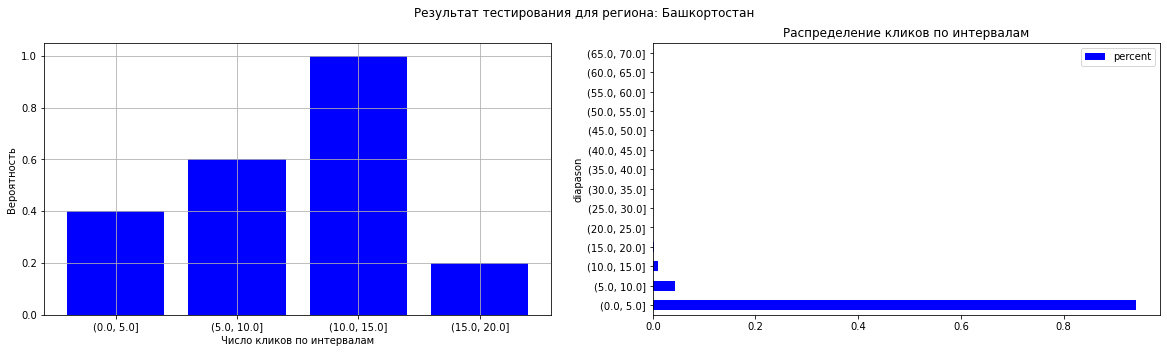

In [9]:
draw_histogram(
    activity_df=bashkortostan_activity,
    histogram=bashkortostan_hist,
    region_name='Башкортостан',
    color='blue'
)

## Республика Татарстан

In [10]:
tatarstan_user_event = pd.read_csv('tatarstan_user_event_df.csv')
tatarstan_user_event.drop(columns='Unnamed: 0', inplace=True)
tatarstan_activity = split_df_into_diapasons(df=tatarstan_user_event)

In [11]:
tatarstan_histogram = get_probability_distribution(
    tatarstan_activity,
    tatarstan_user_event)

Shape: (426, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 1.0
Shape: (821, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.2
Shape: (228, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.6
Shape: (60, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.6


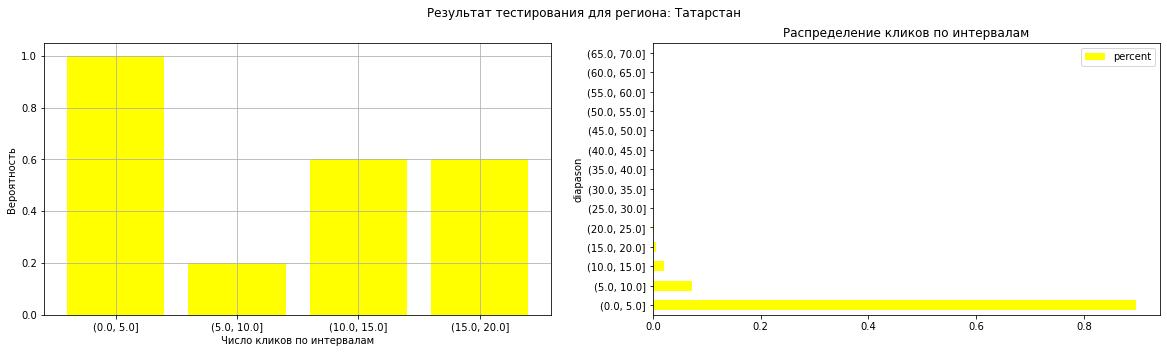

In [12]:
draw_histogram(
    activity_df=tatarstan_activity,
    histogram=tatarstan_histogram,
    region_name='Татарстан',
    color='yellow'
)

## Кемеровская область

In [13]:
kemerov_user_event = pd.read_csv('kemerov_user_event_df.csv')
kemerov_user_event.drop(columns='Unnamed: 0', inplace=True)
kemerov_activity = split_df_into_diapasons(df=kemerov_user_event)

In [14]:
kemerov_hist = get_probability_distribution(
    kemerov_activity,
    kemerov_user_event)

Shape: (148, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.4
Shape: (222, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 1.0
Shape: (65, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.8
Shape: (19, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.4


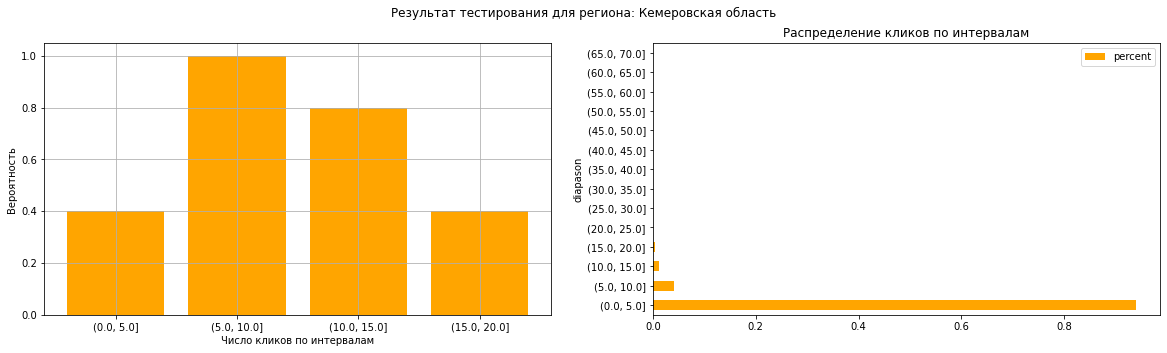

In [15]:
draw_histogram(
    activity_df=kemerov_activity,
    histogram=kemerov_hist,
    region_name='Кемеровская область',
    color='orange'
)

## Новосибирская область

In [16]:
novosib_user_event = pd.read_csv('novosib_user_event_df.csv')
novosib_user_event.drop(columns='Unnamed: 0', inplace=True)
novosib_activity = split_df_into_diapasons(df=novosib_user_event)

In [17]:
novosib_hist = get_probability_distribution(
    novosib_activity,
    novosib_user_event)

Shape: (171, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.2
Shape: (375, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.8
Shape: (85, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.2
Shape: (31, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.6


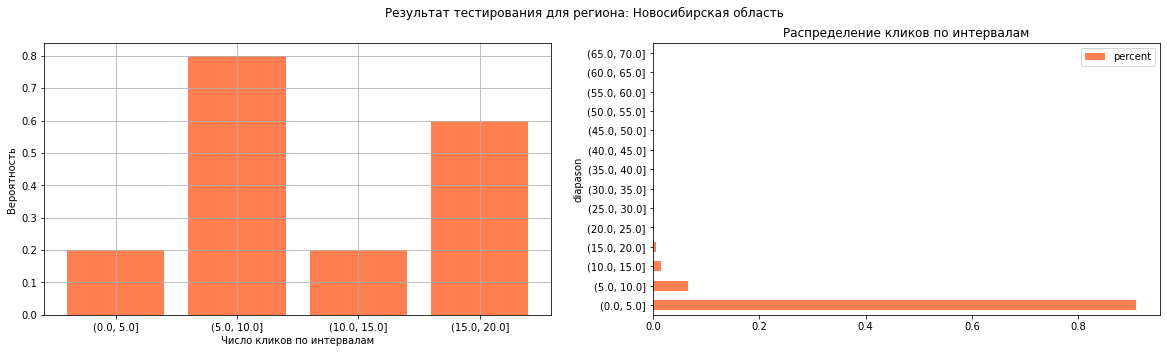

In [18]:
draw_histogram(
    activity_df=novosib_activity,
    histogram=novosib_hist,
    region_name='Новосибирская область',
    color='coral'
)

## Волгоградская область

In [19]:
volgograd_user_event = pd.read_csv('volgograd_user_event_df.csv')
volgograd_user_event.drop(columns='Unnamed: 0', inplace=True)
volgograd_activity = split_df_into_diapasons(df=volgograd_user_event)

In [20]:
volgograd_hist = get_probability_distribution(
    volgograd_activity,
    volgograd_user_event)

Shape: (209, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is equal to zero.
Shape: (337, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.2
Shape: (74, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.2
Shape: (21, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.2


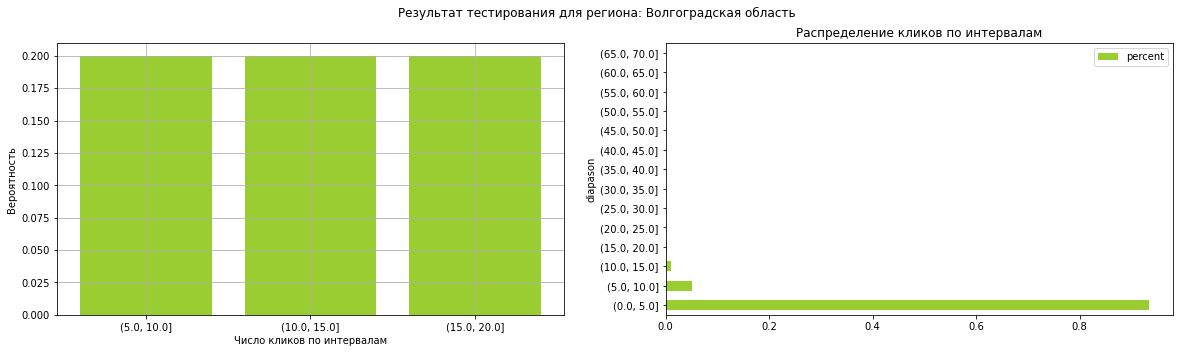

In [21]:
draw_histogram(
    activity_df=volgograd_activity,
    histogram=volgograd_hist,
    region_name='Волгоградская область',
    color='yellowgreen'
)

## Пермский край

In [22]:
perm_user_event = pd.read_csv('perm_user_event_df.csv')
perm_user_event.drop(columns='Unnamed: 0', inplace=True)
perm_activity = split_df_into_diapasons(df=perm_user_event)

In [23]:
perm_hist = get_probability_distribution(
    perm_activity,
    perm_user_event)

Shape: (125, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.2
Shape: (193, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.6
Shape: (34, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.2
Shape: (9, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.4


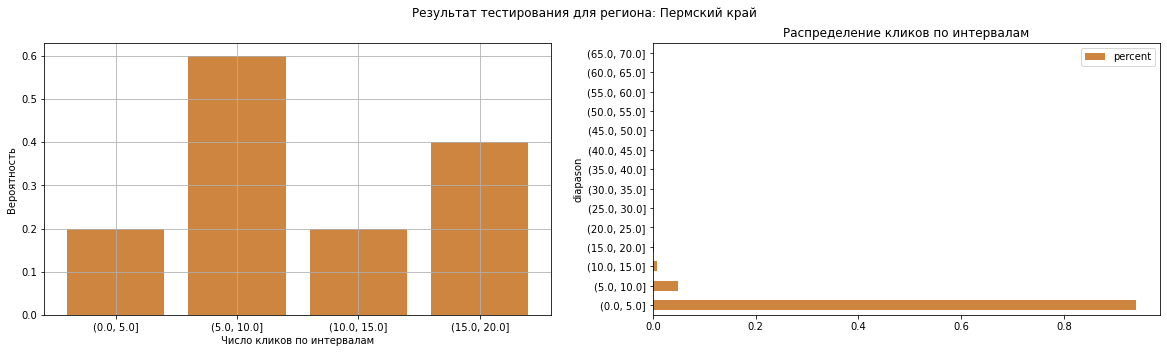

In [24]:
draw_histogram(
    activity_df=perm_activity,
    histogram=perm_hist,
    region_name='Пермский край',
    color='peru'
)

## Республика Дагестан

In [25]:
dagestan_user_event = pd.read_csv('dagestan_user_event_df.csv')
dagestan_user_event.drop(columns='Unnamed: 0', inplace=True)
dagestan_activity = split_df_into_diapasons(df=dagestan_user_event)


In [26]:
dagestan_user_event

,user_id,event_id,event_name,clicks_count
0,005bbb70559ac82250d8099760f7df50,1455576,Спектакль «Если сердце захочет»,11
1,006842ad48bc9232ba53dd73ec81efce,1348444,Экскурсия в Ногайский краеведческий музей,2
2,006e3d7ba1f90d541e0ff4cf7fd7d366,803467,Спектакль «Женитьба Кодолава»,2
3,006e3d7ba1f90d541e0ff4cf7fd7d366,828611,Спектакль «Снежная королева»,1
4,006e3d7ba1f90d541e0ff4cf7fd7d366,1258456,"Спектакль «Не невеста, а золото»",1
...,...,...,...,...
2258,ff02ee1274d47bf613ac20226b368c15,1465146,Экспозиции Дагестанского музея изобразительных...,1
2259,ff59e1682d0c62141492eb159fb6d2eb,1406651,Посещение музейных объектов и выставок города ...,3
2260,ff9f2c9e3a8ca246414bac57f3fbdd5f,1356077,Экскурсия «Культура и быт древнего Дербента»,5
2261,ff9f2c9e3a8ca246414bac57f3fbdd5f,1375433,Экскурсия «Боевая слава»,1


In [27]:
dagestan_histogram = get_probability_distribution(
    dagestan_activity,
    dagestan_user_event)

Shape: (26, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.4
Shape: (54, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.8
Shape: (5, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is: 0.8


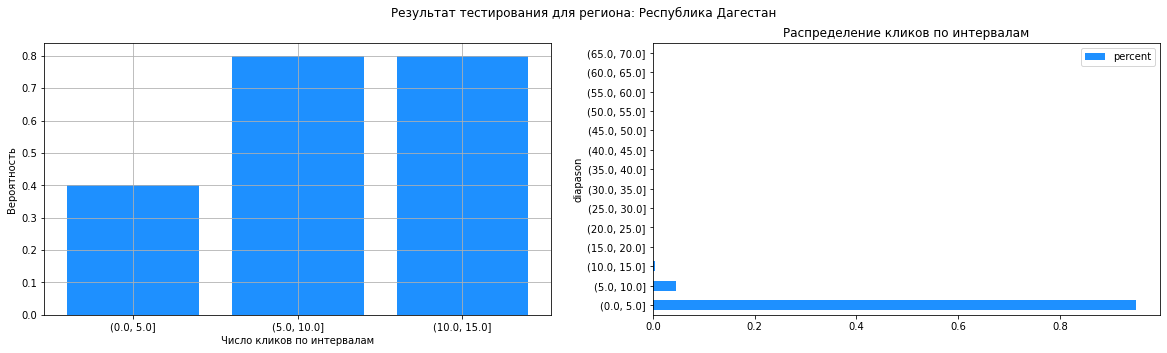

In [28]:
draw_histogram(
    activity_df=dagestan_activity,
    histogram=dagestan_histogram,
    region_name='Республика Дагестан',
    color='dodgerblue'
)

## Свердловская область

In [29]:
sverdlov_user_event = pd.read_csv('sverdlov_user_event_df.csv')
sverdlov_user_event.drop(columns='Unnamed: 0', inplace=True)
sverdlov_activity = split_df_into_diapasons(df=sverdlov_user_event)

In [30]:
sverdlov_user_event

,user_id,event_id,event_name,clicks_count
0,00001deaca68c3e7a9943ad6d29d1a95,1205186,Концерт оркестра UralBand,2
1,00001deaca68c3e7a9943ad6d29d1a95,1237397,Выставка «Антика. Западноевропейское искусство...,1
2,00001deaca68c3e7a9943ad6d29d1a95,1264968,Выставка «От романтизма к импрессионизму. Фран...,1
3,000c4e0211dc8f81060c31c7d73c4194,1237397,Выставка «Антика. Западноевропейское искусство...,2
4,000c4e0211dc8f81060c31c7d73c4194,1238608,Концерт Carmina Burana,1
...,...,...,...,...
10660,ffe4f9f753c55267cd2f9509696c6fd8,1265104,Спектакль «Не все коту масленица»,1
10661,ffea82a4ecdfe36230e99a6ee1345a27,1288591,Опера «Кармен»,1
10662,ffea82a4ecdfe36230e99a6ee1345a27,1340782,Балет «Жизель»,2
10663,ffea82a4ecdfe36230e99a6ee1345a27,1343644,Концерт Queen Tribute,4


In [31]:
sverdlov_hist = get_probability_distribution(
    sverdlov_activity,
    sverdlov_user_event)

Shape: (153, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.6
Shape: (247, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.2
Shape: (48, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is equal to zero.
Shape: (23, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.2


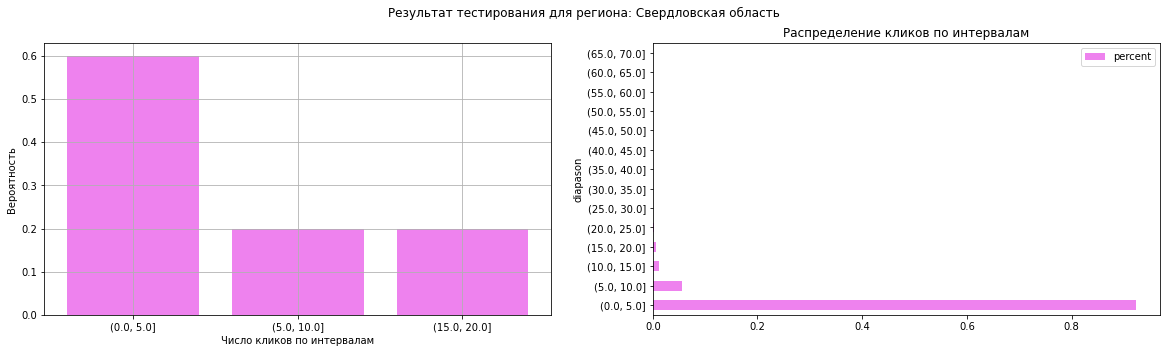

In [32]:
draw_histogram(
    activity_df=sverdlov_activity,
    histogram=sverdlov_hist,
    region_name='Свердловская область',
    color='violet'
)

## Ростовская область

In [33]:
rostov_user_event = pd.read_csv('rostov_user_event_df.csv')
rostov_user_event.drop(columns='Unnamed: 0', inplace=True)
rostov_activity = split_df_into_diapasons(df=rostov_user_event)

In [34]:
rostov_hist = get_probability_distribution(
    rostov_activity,
    rostov_user_event)

Shape: (130, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.2
Shape: (242, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.4
Shape: (41, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is equal to zero.
Shape: (10, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.2


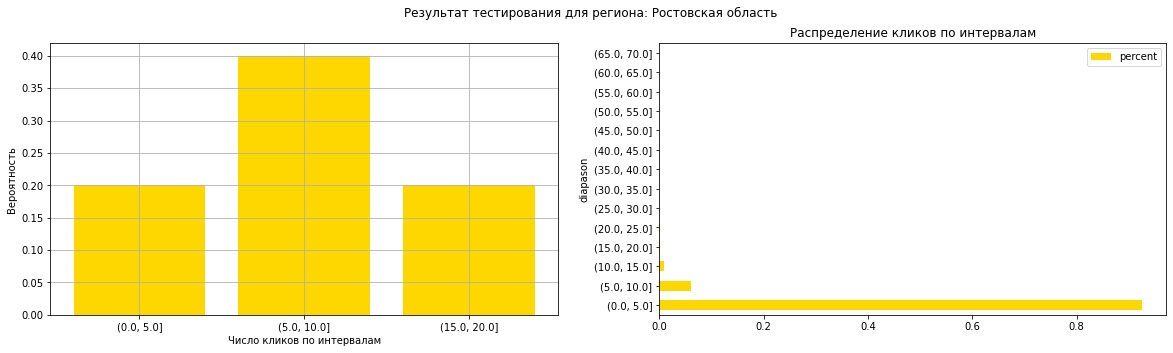

In [35]:
draw_histogram(
    activity_df=rostov_activity,
    histogram=rostov_hist,
    region_name='Ростовская область',
    color='gold'
)

## Самарская область

In [36]:
samara_user_event = pd.read_csv('samara_user_event_df.csv')
samara_user_event.drop(columns='Unnamed: 0', inplace=True)
samara_activity = split_df_into_diapasons(df=samara_user_event)

In [37]:
samara_hist = get_probability_distribution(
    samara_activity,
    samara_user_event)

Shape: (160, 3)
##############################
(0.0, 5.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (0.0, 5.0] probability is: 0.8
Shape: (330, 3)
##############################
(5.0, 10.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (5.0, 10.0] probability is: 0.4
Shape: (73, 3)
##############################
(10.0, 15.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (10.0, 15.0] probability is equal to zero.
Shape: (23, 3)
##############################
(15.0, 20.0]: PROCESSING


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

For (15.0, 20.0] probability is: 0.6


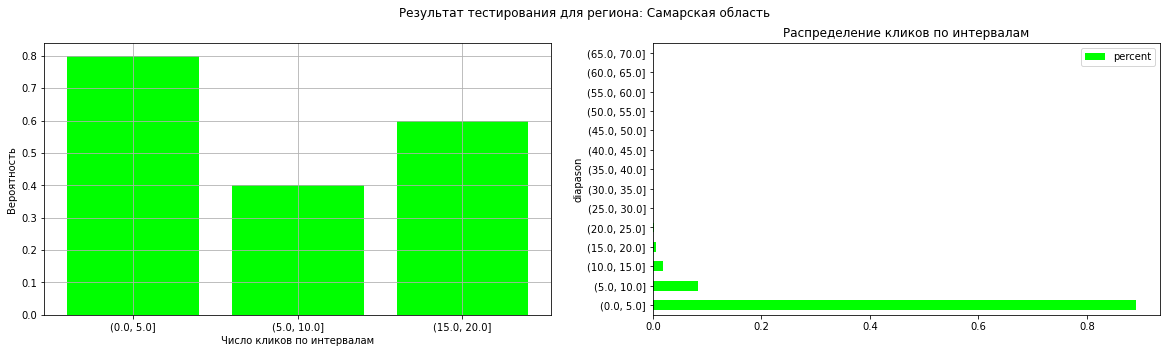

In [38]:
draw_histogram(
    activity_df=samara_activity,
    histogram=samara_hist,
    region_name='Самарская область',
    color='lime'
)